# Stock trend prediction using stacked LSTM

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf

## Basic cleanup and getting to know the data

In [13]:
start = '2010-01-01'
end = '2019-12-31'

df = yf.download('AAPL', start, end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487535,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800


In [14]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,69.261612,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.327438,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.702927,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.676109,146266000
2019-12-30,72.364998,73.172501,71.305000,72.879997,71.095573,144114400


In [15]:
df = df.reset_index()

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487535,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800


In [17]:
df = df.drop(['Date', 'Adj Close'], axis  = 1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


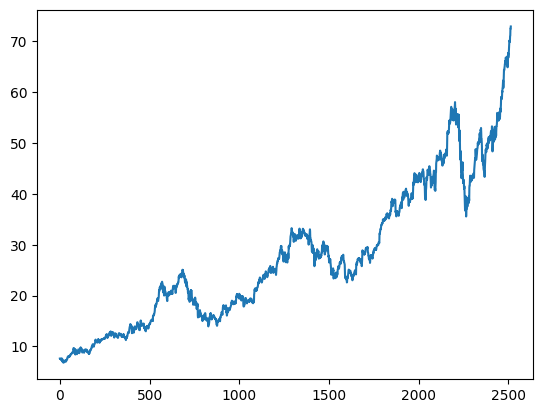

In [18]:
plt.plot(df.Close)

## Moving averages to know the downtrends and uptrends

In [19]:
ma100 = df.Close.rolling(100).mean()
ma100

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2510    59.201075
2511    59.401700
2512    59.643125
2513    59.875125
2514    60.106325
Name: Close, Length: 2515, dtype: float64

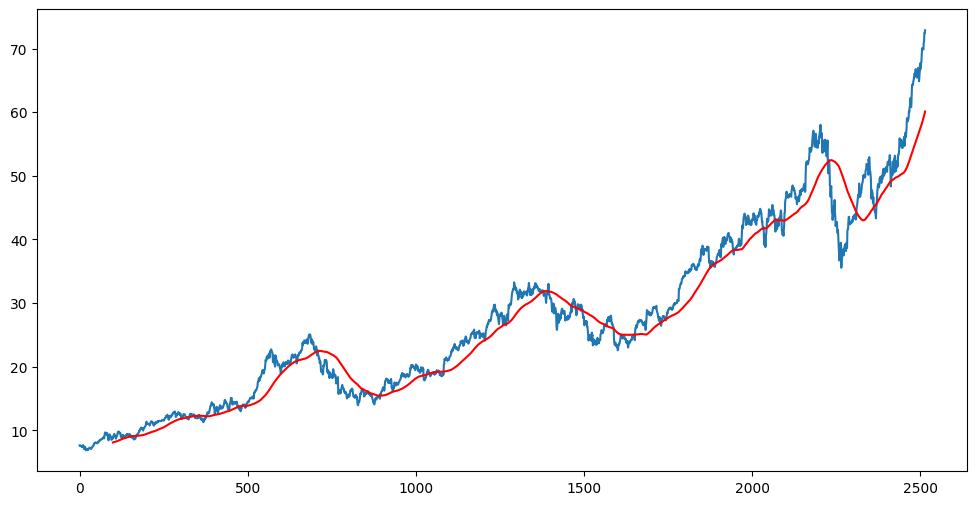

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

In [23]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2510    54.132313
2511    54.261513
2512    54.396763
2513    54.529350
2514    54.661100
Name: Close, Length: 2515, dtype: float64

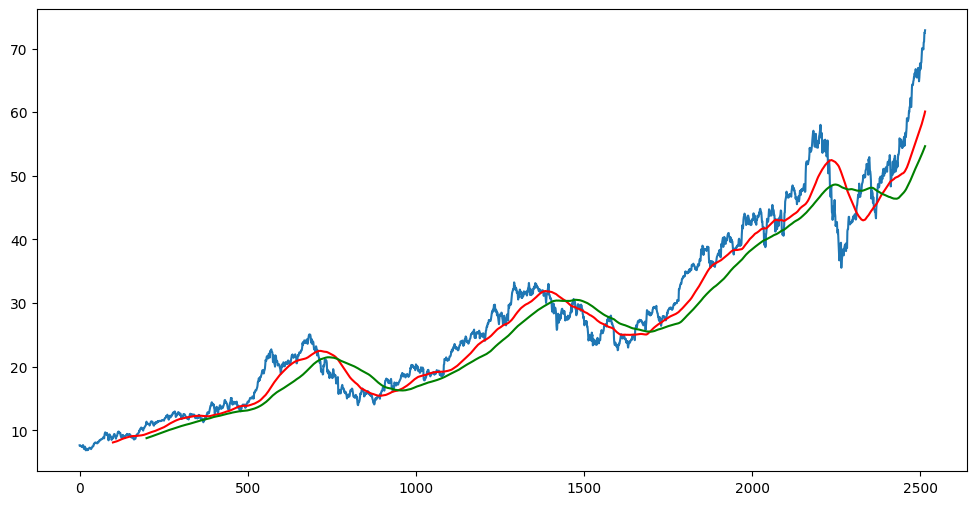

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [25]:
df.shape

(2515, 5)

## Train test splitting 

In [27]:
data_train = pd.DataFrame(df['Close'][0: int(len(df) * 0.70)])
data_test = pd.DataFrame(df['Close'][int(len(df) * 0.70): int(len(df))])

data_train.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


In [28]:
data_test.head()

,Close
1760,29.182501
1761,28.955000
1762,29.037500
1763,29.004999
1764,29.152500


In [29]:
data_train.shape

(1760, 1)

In [30]:
data_test.shape

(755, 1)

## Scale down the data between 0 to 1 for processing via stacked LSTM model 

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

In [32]:
data_train_arr = scaler.fit_transform(data_train)
data_train_arr

array([[0.02971782],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

## Getting all x_train and y_train values 

In [33]:
x_train = []
y_train = []

for i in range(100, data_train_arr.shape[0]):
    x_train.append(data_train_arr[i - 100: i])
    y_train.append(data_train_arr[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

## ML model 

In [34]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [35]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [38]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
52/52 [==============================] - 16s 191ms/step - loss: 0.0599
Epoch 2/50
52/52 [==============================] - 9s 182ms/step - loss: 0.0121
Epoch 3/50
52/52 [==============================] - 9s 180ms/step - loss: 0.0097
Epoch 4/50
52/52 [==============================] - 10s 195ms/step - loss: 0.0092
Epoch 5/50
52/52 [==============================] - 12s 223ms/step - loss: 0.0083
Epoch 6/50
52/52 [==============================] - 13s 252ms/step - loss: 0.0094
Epoch 7/50
52/52 [==============================] - 13s 244ms/step - loss: 0.0087
Epoch 8/50
52/52 [==============================] - 14s 261ms/step - loss: 0.0075
Epoch 9/50
52/52 [==============================] - 14s 262ms/step - loss: 0.0077
Epoch 10/50
52/52 [==============================] - 13s 242ms/step - loss: 0.0071
Epoch 11/50
52/52 [==============================] - 13s 244ms/step - loss: 0.0071
Epoch 12/50
52/52 [==============================] - 15s 279ms/step - loss: 0.0072
Epoch 13/50
52/

In [40]:
model.save('keras_stock_model.keras')

## Preparing test data

In [53]:
data_test.head()

,Close
1760,29.182501
1761,28.955000
1762,29.037500
1763,29.004999
1764,29.152500


In [54]:
past_100_days = data_train.tail(100)

In [55]:
past_100_days

,Close
1660,27.092501
1661,27.202499
1662,27.000000
1663,26.982500
1664,27.045000
...,...
1755,29.264999
1756,29.072500
1757,29.129999
1758,29.315001


In [59]:
final_df = past_100_days._append(data_test, ignore_index = True)

In [60]:
final_df.head()

,Close
0,27.092501
1,27.202499
2,27.000000
3,26.982500
4,27.045000


In [61]:
data_input = scaler.fit_transform(final_df)
data_input

array([[0.02781467],
       [0.03015022],
       [0.02585064],
       [0.02547908],
       [0.02680611],
       [0.03370671],
       [0.03317586],
       [0.03232658],
       [0.03158344],
       [0.03306972],
       [0.02855781],
       [0.03036255],
       [0.02600988],
       [0.02356814],
       [0.02022403],
       [0.01958704],
       [0.01523437],
       [0.01576518],
       [0.01910933],
       [0.02441747],
       [0.02425819],
       [0.02776158],
       [0.01268645],
       [0.        ],
       [0.01226183],
       [0.02558522],
       [0.04586231],
       [0.06603324],
       [0.06258295],
       [0.05547006],
       [0.05541697],
       [0.05531082],
       [0.06099053],
       [0.05085197],
       [0.05175434],
       [0.05286905],
       [0.05743405],
       [0.04803866],
       [0.05265676],
       [0.04984341],
       [0.05239133],
       [0.05265676],
       [0.05711557],
       [0.05801795],
       [0.06858117],
       [0.0699082 ],
       [0.07542863],
       [0.073

In [62]:
data_input.shape

(855, 1)

In [63]:
x_test = []
y_test = []

for i in range(100, data_input.shape[0]):
    x_test.append(data_input[i - 100: i])
    y_test.append(data_input[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

## Making predictions

In [64]:
y_pred = model.predict(x_test)

24/24 [==============================] - 2s 67ms/step


In [65]:
y_pred.shape

(755, 1)

In [66]:
y_test

array([0.0721907 , 0.06736028, 0.06911197, 0.06842189, 0.07155371,
       0.07845431, 0.08418707, 0.08482406, 0.08822126, 0.08556719,
       0.08445249, 0.0895483 , 0.0894952 , 0.0883805 , 0.0895483 ,
       0.08997296, 0.08938906, 0.09952758, 0.0998461 , 0.09989915,
       0.09820055, 0.09671427, 0.1359945 , 0.1348267 , 0.1377462 ,
       0.144169  , 0.15075112, 0.15345824, 0.15547536, 0.1538829 ,
       0.16009341, 0.16927655, 0.17187748, 0.17102824, 0.17299223,
       0.17819418, 0.18037053, 0.1772918 , 0.17798189, 0.17941503,
       0.17973358, 0.1945963 , 0.19019062, 0.19454325, 0.19220766,
       0.19316316, 0.19040291, 0.18870427, 0.19114605, 0.19146452,
       0.19034986, 0.19815283, 0.19937368, 0.195658  , 0.20346096,
       0.19486173, 0.20324859, 0.20059453, 0.19910825, 0.20038224,
       0.21588199, 0.21758055, 0.21657199, 0.21513885, 0.21535114,
       0.22103089, 0.21704978, 0.21513885, 0.21344021, 0.21253783,
       0.20436334, 0.20526571, 0.20128461, 0.20542495, 0.20208

In [67]:
y_test.shape

(755,)

In [68]:
y_pred

array([[0.1198006 ],
       [0.12064379],
       [0.12147863],
       [0.12227719],
       [0.1230188 ],
       [0.12368774],
       [0.12428062],
       [0.12481314],
       [0.1253132 ],
       [0.12580733],
       [0.12632097],
       [0.12686487],
       [0.12744129],
       [0.1280553 ],
       [0.12870556],
       [0.12938431],
       [0.1300826 ],
       [0.13078962],
       [0.13149905],
       [0.13222243],
       [0.13296917],
       [0.13374275],
       [0.13453682],
       [0.13537149],
       [0.13632864],
       [0.13747779],
       [0.13887781],
       [0.14057925],
       [0.14261957],
       [0.14500266],
       [0.14770721],
       [0.15070638],
       [0.15397772],
       [0.15750146],
       [0.16124529],
       [0.1651665 ],
       [0.16922648],
       [0.17339125],
       [0.17761607],
       [0.18184818],
       [0.18602864],
       [0.19009623],
       [0.19402434],
       [0.19779506],
       [0.2013998 ],
       [0.20482795],
       [0.208068  ],
       [0.211

In [69]:
scaler.scale_

array([0.02123255])

In [70]:
scale_factor = 1 / 0.02123255

In [71]:
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

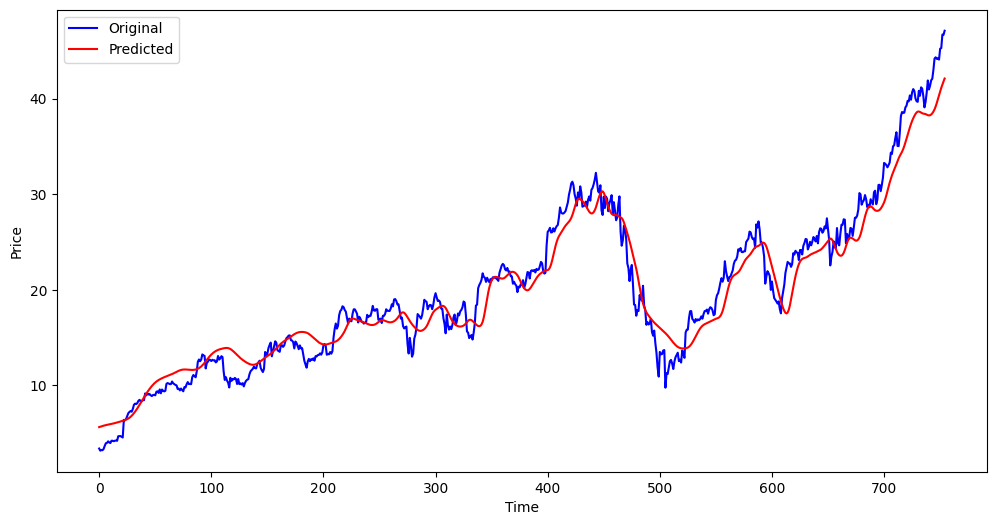

In [72]:
plt.figure(figsize = (12, 6))
plt.plot(y_test, 'b', label = 'Original')
plt.plot(y_pred, 'r', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()